### Train UNet

In this notebook a normal UNet is trained

In [31]:
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import random
from torch.utils.data import DataLoader
import pickle

# Add level above to path
sys.path.append('../')

# This is only done to fix environment error (see https://stackoverflow.com/questions/20554074/sklearn-omp-error-15-initializing-libiomp5md-dll-but-found-mk2iomp5md-dll-a)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Import library functions
import lib.models as m
from lib.utils import train, test, test_equivariance, visualize_test_equivariance
import datasets as d

if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We start by setting the random seeds and defining the DataLoaders

In [7]:
#Set seed
seed = 40
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [8]:
# Set parameters for datasets
batch_size = 64
transform_train = [True,False] # First element is scaling/brightness second is rotation
transform_test = [False,False] # First element is scaling/brightness second is rotation

# Path to the dataset
data_path = "../datasets/data/Fundus_Retina/dataset_2000samples/"

trainset = d.FUNDUS_RETINA(dataset = "train", transform = transform_train, data_path=data_path)
valset = d.FUNDUS_RETINA(dataset = "val", transform = transform_test, data_path=data_path)
testset = d.FUNDUS_RETINA(dataset = "test", transform = transform_test, data_path=data_path)

In [9]:
# Get dataloaders
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

Show images

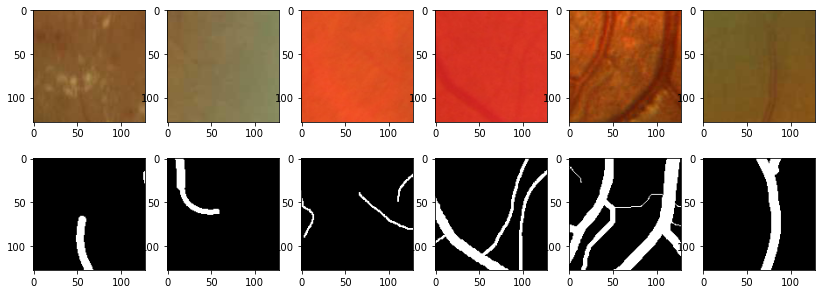

In [10]:
X,y = next(iter(test_loader))
    
# Show 6 or less images
N_imgs = X.shape[0] if X.shape[0] < 6 else 6
imgsize = N_imgs*3 if N_imgs*3 < 14 else 14

f,ax = plt.subplots(2,N_imgs,figsize=(imgsize,5))
ax = ax.flatten()
for i in range(N_imgs):
    ax[i].imshow(np.moveaxis(X[i].numpy(),0,2))
    ax[i+N_imgs].imshow(y[i,0].numpy(),'gray')
plt.show()

### Set Configs for run

In [12]:
config = {
    'epochs': 20,                   # Number of epochs to run
    'batch_size': batch_size,       # Batch size
    'learning_rate': 1e-2,          # Learning rate
    'optimizer': 'adam',            # Optimizer
    'step_lr': [True, 5, 0.1],      # Step learning rate patience and decrease param
    'early_stopping' : 5,           # Early stopping patience
    'loss_func' : 'diceBCE',        # Loss function to use: 'diceBCE', 'IoU' or 'dice'
    # Unet parameters
    'in_channels' : 3,              # Number of input channels
    'out_channels' : 1,             # Number of output channels
    'channels' : [6,12,20],         # Convolution channels in layers
    'n_conv' : 2,                   # Number of convolutions >= 2
    'batch_norm' : True,            # Use batch-norm (True/False)
    'dropout' : 0,                  # Use dropout? (0 <= dropout < 1)
    'kernel_size' : 3,              # Kernel size of all convolutions
    'padding' : 1,                  # Padding on all convolutions
}

In [15]:
# Define model
model = m.UNet(config).to(device)

pytorch_total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:",pytorch_total_params)

Total parameters: 62875


### Train model

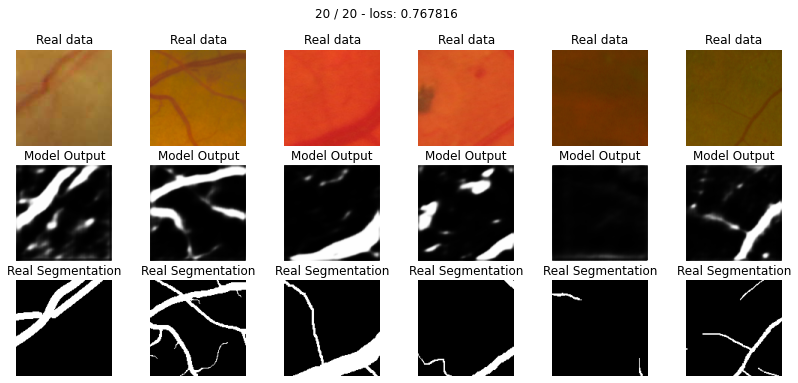

In [16]:
train_dict, val_dict = train(model,config,train_loader,val_loader,plotting=True)

### Performance on test set

In [18]:
test_dict = test(model, test_loader, config)

Testing : 100%|██████████████████████████████████| 7/7 [00:03<00:00,  1.93it/s]


In [21]:
print(test_dict)

{'loss': 0.9594406741006034, 'metrics': array([0.38322002, 0.23710894, 0.86544022, 0.32427696, 0.94566414])}


### Test equivariance

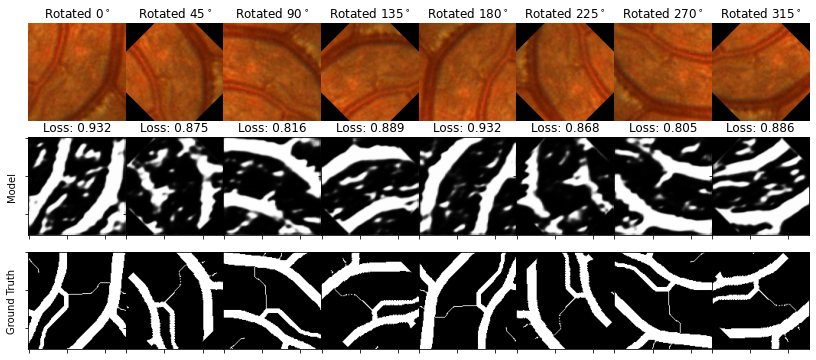

In [26]:
# Which image in the test set to visualize
idx = 4

# Which group to check invariance with respect to
group = "C8"

f,ax = visualize_test_equivariance(model, test_loader, config, idx = idx, group = group)
plt.show()

We (unsuprisingly) see that the model gets a different loss on the different rotations of the same image. This is because the model is not rotation equivariant.

In [28]:
equivariance_dict = test_equivariance(model, test_loader, config, group)

Testing: 100%|███████████████████████████████████| 7/7 [00:02<00:00,  2.62it/s]


In [29]:
equivariance_dict

{'loss': tensor([0.9594, 0.8598, 0.8103, 0.9051, 0.9595, 0.8603, 0.8098, 0.9045]),
 'metrics': tensor([[0.3832, 0.2371, 0.8654, 0.3243, 0.9457],
         [0.4114, 0.2592, 0.8874, 0.3714, 0.9487],
         [0.4638, 0.3021, 0.8715, 0.4310, 0.9368],
         [0.3823, 0.2366, 0.8851, 0.3357, 0.9504],
         [0.3838, 0.2376, 0.8663, 0.3231, 0.9468],
         [0.4103, 0.2582, 0.8884, 0.3662, 0.9504],
         [0.4643, 0.3025, 0.8727, 0.4279, 0.9386],
         [0.3815, 0.2361, 0.8855, 0.3334, 0.9511]]),
 'rotations': [0, 45, 90, 135, 180, 225, 270, 315]}

### Save model

In [32]:
model_path = "saved_models/"
model_name = "UNet"
torch.save(model.state_dict(), model_path + model_name)
# Save dicts
with open(model_path + model_name + ".pkl", 'wb') as f:
    pickle.dump([config, train_dict, val_dict, test_dict], f)